# 4. Stitch outputs together
- Once you have fitted the weak, medium and dense diads, stitch them all together, and apply the Ne correction model

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import DiadFit as pf
pf.__version__

'0.0.91'

In [36]:
# Load in settings, paths, file extensions etc. that you saved in step 1
meta_path, spectra_path, spectra_filetype, prefix, str_prefix, spectra_file_ext, meta_file_ext, TruPower=pf.get_settings()

## Load in specra, and combine

In [37]:
import os
df2=pf.merge_fit_files(path=os.getcwd())
df2.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Diad1_Asym50,Diad1_Asym70,Diad1_Yuan2017_sym_factor,Diad1_Remigi2021_BSF,Diad2_Asym50,Diad2_Asym70,Diad2_Yuan2017_sym_factor,Diad2_Remigi2021_BSF,Diad1_PDF_Model,Diad2_PDF_Model
0,FG04-A1-4,104.522301,0.004337,1283.194620,0.003478,697.781469,1283.194670,1994.277788,0.999045,2.737006,...,1.018707,1.026036,0.037379,0.002863,1.032258,1.029872,0.053716,0.001176,PseudoVoigtModel,PseudoVoigtModel
1,FG04-A1-16,104.107511,0.008988,1284.077860,0.008479,409.626416,1284.077860,1258.691925,1.147977,4.236346,...,1.052711,1.065946,0.121022,0.005605,1.073469,1.072165,0.123820,0.001917,PseudoVoigtModel,PseudoVoigtModel
2,FG04-A1-16_am,104.124146,0.012221,1284.034449,0.010745,259.853391,1284.034449,810.364308,1.171327,3.378279,...,1.138720,1.045989,0.324972,0.009015,1.100642,1.011396,0.165458,0.002964,PseudoVoigtModel,PseudoVoigtModel
3,FG04-A1-4_am,104.560048,0.005368,1283.057553,0.004657,647.465558,1283.057603,1800.083906,0.980021,3.055725,...,1.045375,1.027981,0.088937,0.003027,1.002008,1.001420,0.003319,0.001277,PseudoVoigtModel,PseudoVoigtModel
4,K24_21_FIA,103.201652,0.003084,1286.139381,0.002707,774.398523,1286.139431,1166.209406,0.581940,2.717664,...,1.017647,1.002083,0.020539,0.001503,1.145161,1.148990,0.138681,0.000678,PseudoVoigtModel,PseudoVoigtModel


## First, get the metadata for this day

In [38]:
# Put the common string you can in all your Ne lines here
diad_meta=pf.get_files(path=meta_path,
file_ext=meta_file_ext, exclude_str=['Ne', 'Cap','window'],
 sort=True)
diad_meta[0]

'001 FG04-A1-5X.txt'

## Now get all the important information out of the metadata files

In [39]:
# This will only work for WITEC - for other vendors, you might have to use the file datastamp. See the HORIBA example
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=diad_meta, prefix=prefix, str_prefix=str_prefix,
trupower=TruPower)
meta.head()

100%|██████████| 159/159 [00:00<00:00, 1393.63it/s]

Done
Oof, try not to work after midnight!


,filename,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
2,FG04-A1-16_am.txt,"June 6, 2024\n",June,6.0,5.949,45.0,5.0,50.0,"['0h', '3m', '46s']",9:05:45 AM\n,119145.0,1324.964
3,FG04-A1-4_am.txt,"June 6, 2024\n",June,6.0,5.919,45.0,5.0,50.0,"['0h', '3m', '46s']",9:11:15 AM\n,119475.0,1324.964
4,K24_21_FIA.txt,"June 6, 2024\n",June,6.0,12.162,60.0,4.0,50.0,"['0h', '4m', '1s']",9:30:52 AM\n,120652.0,1324.964
5,K24_22_FIA.txt,"June 6, 2024\n",June,6.0,11.996,60.0,4.0,50.0,"['0h', '4m', '1s']",9:53:07 AM\n,121987.0,1324.964
6,K24_23_FIA.txt,"June 6, 2024\n",June,6.0,11.988,45.0,3.0,50.0,"['0h', '2m', '16s']",10:04:18 AM\n,122658.0,1324.964


## Then get a simple file name you can stitch with the spectra

In [40]:
file_m=pf.extracting_filenames_generic(names=meta['filename'],
   file_ext=meta_file_ext)
# Checks they are all unique
file_m[0]

good job, no duplicate file names


'FG04-A1-16_am'

## Now get filename from spectra into same form as metadata

In [41]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(
    names=df2['filename'].reset_index(drop=True),
   file_ext=spectra_file_ext)

# Remove the cosmic rays, as doesnt have it in the metatdata
file_s = np.char.replace(file_s.astype(str), "_CRR_DiadFit", "")
print(file_s[0])

good job, no duplicate file names
FG04-A1-4


In [42]:
# Combining them together, if the form above matches, e.g. checking one doesnt have a suffix and the other one does

meta['filename']=file_m
df2['filename']=file_s
df_combo=pd.merge(df2, meta, on='filename').reset_index(drop=True)
df_combo.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,FG04-A1-4,104.522301,0.004337,1283.194620,0.003478,697.781469,1283.194670,1994.277788,0.999045,2.737006,...,June,5.0,6.004,45.0,5.0,50.0,"['0h', '3m', '47s']",7:50:54 PM\n,71454.0,1324.964
1,FG04-A1-16,104.107511,0.008988,1284.077860,0.008479,409.626416,1284.077860,1258.691925,1.147977,4.236346,...,June,5.0,5.998,45.0,5.0,50.0,"['0h', '3m', '46s']",7:55:56 PM\n,71756.0,1324.964
2,FG04-A1-16_am,104.124146,0.012221,1284.034449,0.010745,259.853391,1284.034449,810.364308,1.171327,3.378279,...,June,6.0,5.949,45.0,5.0,50.0,"['0h', '3m', '46s']",9:05:45 AM\n,119145.0,1324.964
3,FG04-A1-4_am,104.560048,0.005368,1283.057553,0.004657,647.465558,1283.057603,1800.083906,0.980021,3.055725,...,June,6.0,5.919,45.0,5.0,50.0,"['0h', '3m', '46s']",9:11:15 AM\n,119475.0,1324.964
4,K24_21_FIA,103.201652,0.003084,1286.139381,0.002707,774.398523,1286.139431,1166.209406,0.581940,2.717664,...,June,6.0,12.162,60.0,4.0,50.0,"['0h', '4m', '1s']",9:30:52 AM\n,120652.0,1324.964


## If you have secondary phases, now is the time to merge those in

In [43]:
df_combo_sec_phase=pf.merge_in_carb_SO2(
df_combo=df_combo, file1_name='Carb_Peak_fits.xlsx', file2_name='SO2_Peak_fits.xlsx', 
prefix=prefix, str_prefix=str_prefix, file_ext=spectra_file_ext)
#df_combo_sec_phase.to_excel('FI_fitting_w_sec_phases.xlsx', index=False)

Made a df!
good job, no duplicate file names


## If you have SO2, now is the time to calculate the molar proportion of SO2

In [44]:
if 'Peak_Area_SO2' in df_combo_sec_phase:
    

        SO2_mol_ratio=pf.calculate_SO2_CO2_ratio(SO2_area=df_combo_sec_phase['Peak_Area_SO2'], 
        diad1_area=df_combo_sec_phase['Diad1_Voigt_Area'], diad2_area=df_combo_sec_phase['Diad2_Voigt_Area'], 
                SO2_cross_sec=5.3, diad1_cross_sec=0.89, diad2_cross_sec=1.4)
        

        df_combo_sec_phase['SO2_mol_ratio']=SO2_mol_ratio

## Now we calculate the density using the UC Berkeley Densimeter. 
- If you have your own densimeter, I am happy to add a function for it if you email me (penny_wieser@berkeley.edu)
- This particular function propagates the uncertainty on 1) The neon line correction model 2) the peak fits of the diads themselves 3) The densimeter. 

In [45]:
df=pf.calculate_density_ucb(df_combo=df_combo_sec_phase,
  Ne_pickle_str='Neon_corr_model.pkl',  temp='SupCrit', CI_split=0.67, CI_neon=0.67)
df.head()

1.0070563835395951e-05


,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,SO2_mol_ratio,time,preferred_values,lower_values,upper_values
0,FG04-A1-4,0.679868,0.003256,0.002213,0.002388,104.306392,0.004366,0.000581,0.004337,6.004,...,NaN,NaN,NaN,NaN,NaN,NaN,71454.0,0.997934,0.997929,0.997940
1,FG04-A1-16,0.480376,0.004752,0.004129,0.002353,103.892543,0.008988,0.000580,0.008988,5.998,...,NaN,NaN,NaN,NaN,NaN,NaN,71756.0,0.997935,0.997930,0.997941
2,FG04-A1-16_am,0.505333,0.006155,0.005686,0.002356,103.946553,0.012232,0.000880,0.012221,5.949,...,NaN,NaN,NaN,NaN,NaN,NaN,119145.0,0.998294,0.998286,0.998303
3,FG04-A1-4_am,0.718630,0.003692,0.002807,0.002398,104.382143,0.005432,0.000887,0.005368,5.919,...,NaN,NaN,NaN,NaN,NaN,NaN,119475.0,0.998299,0.998290,0.998307
4,K24_21_FIA,0.109894,0.004019,0.001269,0.003814,103.027596,0.003203,0.000885,0.003084,12.162,...,1151.436623,213.776794,126.222271,PseudoVoigtModel,0.073744,0.030879,120652.0,0.998313,0.998305,0.998322


In [46]:
df=pf.calculate_density_ucb(df_combo=df_combo_sec_phase,
  Ne_pickle_str='Neon_corr_model.pkl',  temp='SupCrit', CI_split=0.67, CI_neon=0.67)
df.head()

1.0070563835395951e-05


,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,SO2_mol_ratio,time,preferred_values,lower_values,upper_values
0,FG04-A1-4,0.679868,0.003256,0.002213,0.002388,104.306392,0.004366,0.000581,0.004337,6.004,...,NaN,NaN,NaN,NaN,NaN,NaN,71454.0,0.997934,0.997929,0.997940
1,FG04-A1-16,0.480376,0.004752,0.004129,0.002353,103.892543,0.008988,0.000580,0.008988,5.998,...,NaN,NaN,NaN,NaN,NaN,NaN,71756.0,0.997935,0.997930,0.997941
2,FG04-A1-16_am,0.505333,0.006155,0.005686,0.002356,103.946553,0.012232,0.000880,0.012221,5.949,...,NaN,NaN,NaN,NaN,NaN,NaN,119145.0,0.998294,0.998286,0.998303
3,FG04-A1-4_am,0.718630,0.003692,0.002807,0.002398,104.382143,0.005432,0.000887,0.005368,5.919,...,NaN,NaN,NaN,NaN,NaN,NaN,119475.0,0.998299,0.998290,0.998307
4,K24_21_FIA,0.109894,0.004019,0.001269,0.003814,103.027596,0.003203,0.000885,0.003084,12.162,...,1151.436623,213.776794,126.222271,PseudoVoigtModel,0.073744,0.030879,120652.0,0.998313,0.998305,0.998322


### This cell saves the merged together dataframe with the folder name and the date you fitted it

In [47]:

from datetime import date
today = date.today()
today_str = today.strftime("%Y-%m-%d")
sorted_df = df.sort_values('sec since midnight')
date=meta['date'].iloc[0].replace('\n', '')
name='Raman_session_'+date+'_fitted_'+today_str+'.xlsx'
print(name)
sorted_df.to_excel(name)

Raman_session_June 6, 2024_fitted_2024-06-07.xlsx


In [48]:
df_1974=sorted_df[sorted_df['filename'].str.contains('KL09')]
sorted_df=sorted_df[sorted_df['filename'].str.contains('K24')]

In [49]:
sorted_df

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Model_name,SO2_Diad_Ratio,SO2_mol_ratio,time,preferred_values,lower_values,upper_values
4,K24_21_FIA,0.109894,0.004019,0.001269,0.003814,103.027596,0.003203,0.000885,0.003084,12.162,...,1151.436623,213.776794,126.222271,PseudoVoigtModel,0.073744,0.030879,120652.0,0.998313,0.998305,0.998322
5,K24_22_FIA,0.078046,0.004036,0.001349,0.003803,102.947222,0.003406,0.000895,0.003291,11.996,...,NaN,NaN,NaN,NaN,NaN,NaN,121987.0,0.998331,0.998322,0.998339
7,K24_23_FIA,0.060749,0.004168,0.001668,0.003820,102.903570,0.004209,0.000900,0.004118,11.988,...,NaN,NaN,NaN,NaN,NaN,NaN,122658.0,0.998339,0.998331,0.998348
8,K24_24_FIA,0.134676,0.004025,0.001150,0.003858,103.090141,0.002903,0.000912,0.002761,12.120,...,NaN,NaN,NaN,NaN,NaN,NaN,123877.0,0.998356,0.998347,0.998365
9,K24_24_FIB,0.117634,0.004047,0.001325,0.003824,103.047131,0.003345,0.000914,0.003223,12.152,...,NaN,NaN,NaN,NaN,NaN,NaN,124165.0,0.998360,0.998351,0.998368
10,K24_25_FIA,0.049037,0.004743,0.002785,0.003839,102.874012,0.007029,0.000924,0.006979,12.209,...,NaN,NaN,NaN,NaN,NaN,NaN,125550.0,0.998378,0.998370,0.998387
13,K24_26_FIA,0.087775,0.007709,0.006707,0.003801,102.971776,0.016926,0.000945,0.016927,12.195,...,NaN,NaN,NaN,NaN,NaN,NaN,127920.0,0.998412,0.998403,0.998421
14,K24_27_FIA,0.145477,0.004015,0.001010,0.003886,103.117399,0.002549,0.000953,0.002368,12.182,...,1151.242610,697.928384,416.000887,PseudoVoigtModel,0.150894,0.061207,128701.0,0.998423,0.998414,0.998432
16,K24_28_FIA,0.139639,0.004923,0.003043,0.003870,103.102666,0.007681,0.000956,0.007633,12.178,...,NaN,NaN,NaN,NaN,NaN,NaN,129120.0,0.998429,0.998420,0.998438
17,K24_29_FIA,0.093702,0.006099,0.004769,0.003802,102.986733,0.012036,0.000960,0.012016,12.164,...,NaN,NaN,NaN,NaN,NaN,NaN,129714.0,0.998438,0.998428,0.998447


## This helps visualize the errors on each spectra 

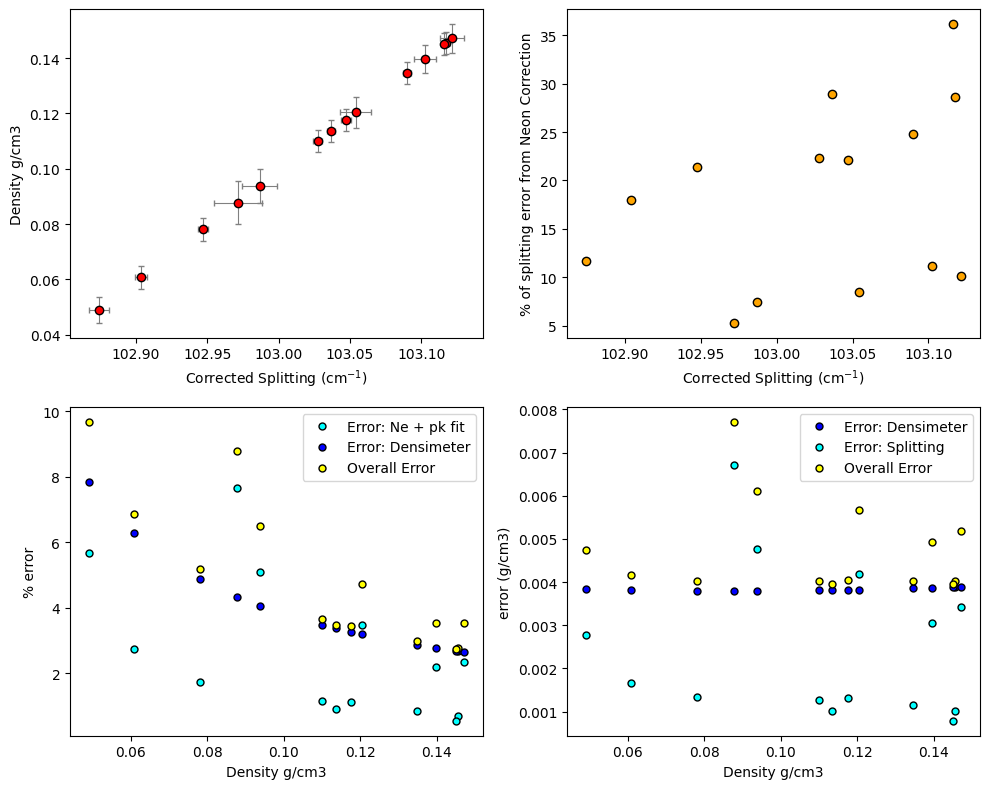

In [50]:
df=sorted_df
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
df=df.loc[df['Density g/cm3']>0]
ax1.errorbar(df['Corrected_Splitting'], df['Density g/cm3'],
xerr=df['Corrected_Splitting_σ'], yerr=df['σ Density g/cm3'],
fmt='o', ecolor='grey', elinewidth=0.8, mfc='red', ms=6, mec='k', capsize=2)
ax1.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax1.set_ylabel('Density g/cm3')

ax2.plot(df['Corrected_Splitting'], 
100*df['Corrected_Splitting_σ_Ne']/(df['Corrected_Splitting_σ_Ne']+df['Corrected_Splitting_σ_peak_fit']),
 'ok', mfc='orange')
ax2.set_ylabel('% of splitting error from Neon Correction')
ax2.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from Ne+peakfit)']/df['Density g/cm3'], 
'ok', mfc='cyan', ms=5, label='Error: Ne + pk fit')


ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from densimeter)']/df['Density g/cm3'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')

ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3']/df['Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax3.set_ylabel('% error')
ax3.set_xlabel('Density g/cm3')
ax3.legend()

ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from densimeter)'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from Ne+peakfit)'], 
'ok', mfc='cyan', ms=5, label='Error: Splitting')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax4.set_ylabel('error (g/cm3)')
ax4.set_xlabel('Density g/cm3')
ax4.legend()

fig.tight_layout()

## If you were analysing fluid inclusions, lets calculate their pressures
- This bit isn't valid for melt inclusion vapour bubbles. 

Text(0, 0.5, '# of FI')

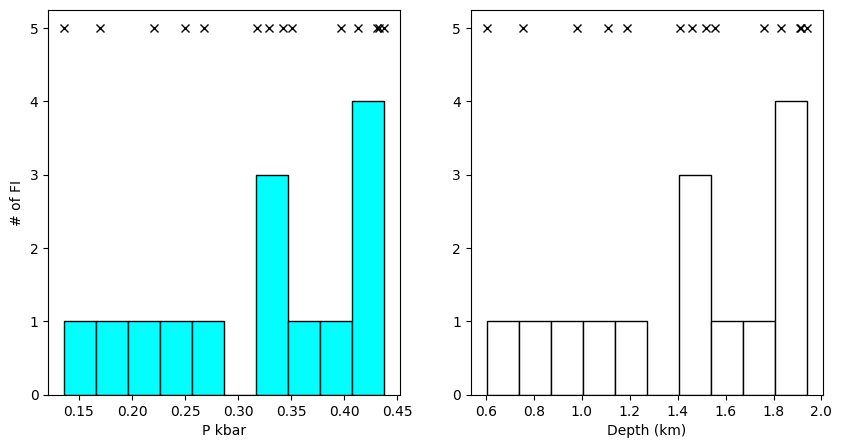

In [51]:
# Calculate pressure with a temperature estimate


Temp_C=1150
Pressure_SW96=pf.calculate_P_for_rho_T(T_K=Temp_C+273.15,
                CO2_dens_gcm3=df['Density g/cm3'],
                 EOS='SW96')
# Calculate depth from a crustal density assumption
Depth=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'], 
                crust_dens_kgm3=2300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(Pressure_SW96['P_kbar'], ec='k', fc='cyan', bins=10)
ax1.plot(Pressure_SW96['P_kbar'], Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.plot(Depth, Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.hist(Depth, ec='k', fc='white', bins=10)
ax1.set_xlabel('P kbar')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('# of FI')